In [104]:
#Importing some necessary packages

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

### Define functions

In [52]:
# A function that allows us to drop rows based on values we think are suspect

def drop_anomolous_rows(df, colname, val):
    return df[df[colname] != val]

In [53]:
# A function to take columns with years (yr_built, yr_renovated) and bin them by decade

from sklearn.preprocessing import LabelEncoder

def bin_by_decade(df, colname):
    bins = pd.IntervalIndex.from_tuples([(1900, 1909), (1910, 1919), (1920, 1929), (1930, 1939), (1940, 1949), (1950, 1959), (1960, 1969), (1970, 1979), (1980, 1989), (1990, 1999), (2000, 2010), (2010, 2020)])
    series = pd.cut(df[colname], bins)
    df[colname] = series
    return df

In [54]:
# Contains all of our data cleaning operations

def clean():
    
# Load the data
    
    house = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/dsc-v2-mod1-final-project-dc-ds-career-042219/master/kc_house_data.csv')
    
# Get rid of rows
    # The row with 33 bedrooms is a suspicious outlier, so we decided to drop it
    # The 454 ?s in sqft_basement needed to be remedied. We chose to drop them--454 seemed like too many to impute. 

    clean_house = drop_anomolous_rows(house, 'bedrooms', 33)
    clean_house = drop_anomolous_rows(house, 'sqft_basement', "?")
    
# Bin decades
    
    clean_house = bin_by_decade(clean_house, 'yr_built')
    clean_house = bin_by_decade(clean_house, 'yr_renovated')
    
    
# Get dummies
    # Note: Originally, we dropped waterfront because it had a lot of null values. Get dummies gives you the option to create a dummy for nulls or not.
    # We did that, without the null column
    clean_house = pd.get_dummies(clean_house, columns=(['waterfront', 'view', 'floors', 'bedrooms', 'condition', 'zipcode', 'yr_built', 'yr_renovated']))
    
# Drop id, date, waterfront

    clean_house = clean_house.drop(['id', 'date'], axis=1)
    
# Convert sqft_basement from object to float

    clean_house['sqft_basement'] = clean_house['sqft_basement'].astype(float, inplace=True)

# Return clean_house
    
    return clean_house

### Get clean dataframe

In [55]:
clean_house = clean()


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [78]:
clean_house.iloc[:, 10:20].head()

,sqft_lot15,waterfront_0.0,waterfront_1.0,view_0.0,view_1.0,view_2.0,view_3.0,view_4.0,floors_1.0,floors_1.5
0,5650,0,0,1,0,0,0,0,1,0
1,7639,1,0,1,0,0,0,0,0,0
2,8062,1,0,1,0,0,0,0,1,0
3,5000,1,0,1,0,0,0,0,1,0
4,7503,1,0,1,0,0,0,0,1,0


In [57]:
clean_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Columns: 135 entries, price to yr_renovated_(2010, 2020]
dtypes: float64(5), int64(6), uint8(124)
memory usage: 4.4 MB


### Split the data into training and test sets

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
# Split data into train and test sets

X = clean_house.drop(["price"], axis=1) #predictors
y = clean_house["price"] #target

In [60]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=3)
print(len(X_test), len(X_train), len(y_test), len(y_train))

4229 16914 4229 16914


### Checking out various combinations 

In [63]:
X2 = clean_house[['waterfront_1.0']]
y2 = clean_house["price"]

In [64]:
predictors_int2 = sm.add_constant(X2)
model = sm.OLS(y2, predictors_int2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     1609.
Date:                Tue, 07 May 2019   Prob (F-statistic):               0.00
Time:                        20:26:00   Log-Likelihood:            -3.0019e+05
No. Observations:               21143   AIC:                         6.004e+05
Df Residuals:                   21141   BIC:                         6.004e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5.325e+05   2448.474    217.467      0.000    5.28e+05    5.37e+05
waterfront_1.0  1.199e+06   2.99e+04     40.117      0.000    1.14e+06    1.26e+06
==============================================================================
Omnibus:                    17340.413   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           897689.905
Skew:                           3.599   Prob(JB):                         0.00
Kurtosis:                      34.099   Cond. No.                         12.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Regression 1: Manual scaling and feature selection

In [79]:
# copied function from Model Fit Linear Regression Lab

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [82]:
target = clean_house["price"]
predictors = clean_house.drop(["price"], axis=1)

result = stepwise_selection(predictors, target, verbose = True)
print('resulting features:')
print(result)

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Add  waterfront_1.0                 with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  sqft_living                    with p-value 0.0
Drop bathrooms                      with p-value 0.611508


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Add  zipcode_98004                  with p-value 0.0
Add  lat                            with p-value 0.0
Add  grade                          with p-value 0.0
Add  zipcode_98039                  with p-value 6.2004e-297
Add  view_0.0                       with p-value 3.39298e-249
Add  zipcode_98112                  with p-value 1.18467e-241
Add  zipcode_98040                  with p-value 1.67766e-195
Add  zipcode_98105                  with p-value 5.57944e-84
Add  condition_3                    with p-value 1.02155e-79
Add  zipcode_98119                  with p-value 4.35741e-80
Add  view_4.0                       with p-value 8.65977e-76
Add  zipcode_98199                  with p-value 2.17883e-61
Add  zipcode_98109                  with p-value 1.53737e-61
Add  zipcode_98102                  with p-value 1.05391e-62
Add  zipcode_98033                  with p-value 2.59056e-56
Add  zipcode_98103                  with p-value 8.23958e-56
Add  zipcode_98115                  with p-va

In [116]:
import statsmodels.api as sm
from sklearn import preprocessing

# Used Scikitlearn's Standard Scaler
    # Takes each data point, subtracts the mean of the sample, then divides by the standard deviation of the sample

ss_scaler = preprocessing.StandardScaler()
clean_house_ss = ss_scaler.fit_transform(clean_house)

# Standard scaler returns a numpy array, so we converted it back to a DF

clean_house_ss = pd.DataFrame(clean_house_ss, columns=list(clean_house.columns))

# We generated a list of features to use using a stepwise selection function from Flatiron's learn.co lessons
    # Finds the best p values from your features

clean_house_selections_list = ['price', 'waterfront_1.0', 'sqft_living', 'zipcode_98004', 'lat', 'grade', 'zipcode_98039', 'view_0.0', 'zipcode_98112', 'zipcode_98040', 'zipcode_98105', 'condition_3', 'zipcode_98119', 'view_4.0', 'zipcode_98199', 'zipcode_98109', 'zipcode_98102', 'zipcode_98033', 'zipcode_98103', 'zipcode_98115', 'zipcode_98122', 'zipcode_98117', 'zipcode_98006', 'zipcode_98116', 'zipcode_98107', 'zipcode_98144', 'sqft_above', 'sqft_basement', 'floors_2.0', 'zipcode_98136', 'floors_3.0', 'zipcode_98005', 'yr_renovated_(2000, 2010]', 'zipcode_98126', 'bedrooms_4', 'zipcode_98029', 'zipcode_98118', 'zipcode_98008', 'view_3.0', 'condition_5', 'zipcode_98027', 'zipcode_98052', 'bedrooms_2', 'zipcode_98007', 'bedrooms_5', 'zipcode_98019', 'zipcode_98028', 'bedrooms_1', 'bedrooms_3', 'bathrooms', 'zipcode_98106', 'yr_built_(1930, 1939]', 'yr_built_(1940, 1949]', 'zipcode_98075', 'zipcode_98011', 'zipcode_98155', 'zipcode_98077', 'sqft_lot', 'yr_built_(1920, 1929]', 'yr_built_(2010, 2020]', 'yr_built_(1910, 1919]', 'floors_1.5', 'zipcode_98072', 'zipcode_98014', 'zipcode_98133', 'zipcode_98022', 'zipcode_98010', 'yr_built_(1970, 1979]', 'zipcode_98178', 'bedrooms_6', 'yr_built_(1900, 1909]', 'zipcode_98002', 'sqft_living15', 'yr_renovated_(2010, 2020]', 'bedrooms_8', 'zipcode_98058', 'zipcode_98070', 'zipcode_98065', 'yr_built_(1960, 1969]']
print(len(clean_house_selections_list))

# Made a new DF with just the features from our selections list
clean_house_selections = clean_house_ss[clean_house_selections_list]

# Used statsmodels OLS so we could get a handy summary of the regression results
target = clean_house_selections["price"]
predictors = clean_house_selections.drop(["price"], axis=1)

predictors_int = sm.add_constant(predictors)
model = sm.OLS(target, predictors_int).fit()
model.summary()

79


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     1180.
Date:                Tue, 07 May 2019   Prob (F-statistic):               0.00
Time:                        21:01:06   Log-Likelihood:                -12341.
No. Observations:               21143   AIC:                         2.484e+04
Df Residuals:                   21065   BIC:                         2.546e+04
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -1.172e-14      0.003  -3.92e-12      1.000      -0.006       0.006
waterfront_1.0                0.1332      0.004     36.163      0.000       0.126       0.140
sqft_living                   0.2455      0.004     69.193      0.000       0.239       0.252
zipcode_98004                 0.2056      0.003     65.660      0.000       0.200       0.212
lat                           0.2086      0.005     44.311      0.000       0.199       0.218
grade                         0.1814      0.006     31.525      0.000       0.170       0.193
zipcode_98039                 0.1497      0.003     49.436      0.000       0.144       0.156
view_0.0                     -0.0606      0.004    -15.437      0.000      -0.068      -0.053
zipcode_98112                 0.1396      0.003     43.791      0.000       0.133       0.146
zipcode_98040                 0.1233      0.003     39.395      0.000       0.117       0.129
zipcode_98105                 0.0807      0.003     25.486      0.000       0.075       0.087
condition_3                  -0.0332      0.004     -9.171      0.000      -0.040      -0.026
zipcode_98119                 0.0816      0.003     25.941      0.000       0.075       0.088
view_4.0                      0.0883      0.004     22.575      0.000       0.081       0.096
zipcode_98199                 0.0706      0.003     22.180      0.000       0.064       0.077
zipcode_98109                 0.0644      0.003     20.959      0.000       0.058       0.070
zipcode_98102                 0.0673      0.003     21.904      0.000       0.061       0.073
zipcode_98033                 0.0686      0.003     21.498      0.000       0.062       0.075
zipcode_98103                 0.0702      0.004     20.054      0.000       0.063       0.077
zipcode_98115                 0.0615      0.003     18.381      0.000       0.055       0.068
zipcode_98122                 0.0623      0.003     19.546      0.000       0.056       0.069
zipcode_98117                 0.0538      0.003     15.947      0.000       0.047       0.060
zipcode_98006                 0.0608      0.003     19.147      0.000       0.055       0.067
zipcode_98116                 0.0529      0.003     16.893      0.000       0.047       0.059
zipcode_98107                 0.0510      0.003     15.890      0.000       0.045       0.057
zipcode_98144                 0.0511      0.003     16.164      0.000       0.045       0.057
sqft_above                    0.2524      0.004     65.591      0.000       0.245       0.260
sqft_basement                 0.0371      0.004     10.582      0.000       0.030       0.044
floors_2.0                   -0.0894      0.005    -19.055      0.000      -0.099      -0.080
zipcode_98136                 0.0402      0.003     13.020      0.000      

### Model Validation

In [85]:
# We needed a special train, test, split for our altered data set

X1_train,X1_test,y1_train,y1_test=train_test_split(predictors,target,test_size=0.2,random_state=3)

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X1_train, y1_train)

y_hat_train = linreg.predict(X1_train)
y_hat_test = linreg.predict(X1_test)

In [128]:
# Check the mean squared error

mse_train = sqrt(np.sum((y_train-y_hat_train)**2)/len(y_train))
mse_test = sqrt(np.sum((y_test-y_hat_test)**2)/len(y_test))
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 160049.94367147383
Test Mean Squarred Error: 156904.21085006962


In [87]:
# Cross validation scores
    # Took the mean cv score because cross_val_score returns a score for each fold

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

cv_5_results = np.mean(cross_val_score(linreg, X, y, cv=5, scoring="neg_mean_squared_error"))
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=20, scoring="neg_mean_squared_error"))

In [88]:
print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

-36000388037.17259
-3460842866955.49
-126057102063.8781


### Regression 2: Lasso

In [89]:
from sklearn.linear_model import Lasso

In [90]:
# Lasso Regression
    # Lasso helps prevent overfitting by reducing the influence of some of the predictors by penalizing their coefficients or reducing them to zero (effectively doing predictor selection)

lasso = Lasso()
lasso.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [91]:
# Checking the training/test scores (R2) of our model 

train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)

In [92]:
print("training score:", train_score)
print("test score: ", test_score)

training score: 0.8136391869874172
test score:  0.8069445302396594


In [93]:
# Checking to see how many features were used and how many were axed

coeff_used = np.sum(lasso.coef_!=0)
print("number of features used:", coeff_used)
print("number eliminated:", len(list(clean_house.columns)) - coeff_used)

number of features used: 129
number eliminated: 6


In [124]:
# Mean Squared Error

from math import sqrt

y_hat_train = lasso.predict(X_train)
y_hat_test = lasso.predict(X_test)

mse_train = sqrt(np.sum((y_train-y_hat_train)**2)/len(y_train))
mse_test = sqrt(np.sum((y_test-y_hat_test)**2)/len(y_test))
print('Train Root Mean Squarred Error:', mse_train)
print('Test Root Mean Squarred Error:', mse_test)

Train Root Mean Squarred Error: 160093.67514929673
Test Root Mean Squarred Error: 157035.18141621255


In [125]:
# Cross Validation

cv_5_results = np.mean(cross_val_score(lasso, X, y, cv=5, scoring="neg_mean_squared_error"))
cv_10_results = np.mean(cross_val_score(lasso, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_20_results = np.mean(cross_val_score(lasso, X, y, cv=20, scoring="neg_mean_squared_error"))

In [126]:
print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

-26199746025.946964
-26113016000.716778
-25954632087.912758


### Regression 3: Ridge

In [105]:
from sklearn.linear_model import Ridge

In [106]:
# An important difference between Lasso and Ridge is that Ridge doesn't reduce any features' coefficient to 0 (though they can get very, very small)

ridge = Ridge()
ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [107]:
# Getting the scores

rtrain_score=ridge.score(X_train,y_train)
rtest_score=ridge.score(X_test,y_test)

In [108]:
print("training score:", rtrain_score)
print("test score: ", rtest_score)

training score: 0.8136008450949628
test score:  0.80715057788118


In [127]:
# Mean Squared Error

y_hat_train = ridge.predict(X_train)
y_hat_test = ridge.predict(X_test)

mse_train = sqrt(np.sum((y_train-y_hat_train)**2)/len(y_train))
mse_test = sqrt(np.sum((y_test-y_hat_test)**2)/len(y_test))
print('Train Root Mean Squarred Error:', mse_train)
print('Test Root Mean Squarred Error:', mse_test)

Train Root Mean Squarred Error: 160049.94367147383
Test Root Mean Squarred Error: 156904.21085006962


In [111]:
# Cross Validation

cv_5_results = np.mean(cross_val_score(ridge, X, y, cv=5, scoring="neg_mean_squared_error"))
cv_10_results = np.mean(cross_val_score(ridge, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_20_results = np.mean(cross_val_score(ridge, X, y, cv=20, scoring="neg_mean_squared_error"))

In [112]:
print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

-26192705525.218136
-26113909169.27703
-25955490873.20748


### Try Gridsearch for best alpha

In [113]:
from sklearn.model_selection import GridSearchCV

In [114]:
param = {'alpha': [0.001, 0.01, 1, 5, 10, 20, 100]}

In [115]:
lasso_regressor = GridSearchCV(lasso, param, scoring='neg_mean_squared_error', cv=10)
lasso_regressor.fit(X, y)

print('Best parameters:', lasso_regressor.best_params_)
print('Best score:', lasso_regressor.best_score_)

Best parameters: {'alpha': 20}
Best score: -26113231427.35375


In [118]:
lasso = Lasso(alpha = 20)
lasso.fit(X_train, y_train)

Lasso(alpha=20, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [119]:
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)

In [120]:
print("training score:", train_score)
print("test score: ", test_score)

training score: 0.8134989690934248
test score:  0.8068284942439361


In [121]:
coeff_used = np.sum(lasso.coef_!=0)
print("number of features used:", coeff_used)
print("number eliminated:", len(list(clean_house.columns)) - coeff_used)

number of features used: 123
number eliminated: 12


In [129]:
# Mean Squared Error
y_hat_train = lasso.predict(X_train)
y_hat_test = lasso.predict(X_test)

mse_train = sqrt(np.sum((y_train-y_hat_train)**2)/len(y_train))
mse_test = sqrt(np.sum((y_test-y_hat_test)**2)/len(y_test))
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 160093.67514929673
Test Mean Squarred Error: 157035.18141621255


In [123]:
# Cross Validation

cv_5_results = np.mean(cross_val_score(lasso, X, y, cv=5, scoring="neg_mean_squared_error"))
cv_10_results = np.mean(cross_val_score(lasso, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_20_results = np.mean(cross_val_score(lasso, X, y, cv=20, scoring="neg_mean_squared_error"))

In [117]:
print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

-26192705525.218136
-26113909169.27703
-25955490873.20748


ValueError: x and y must be the same size

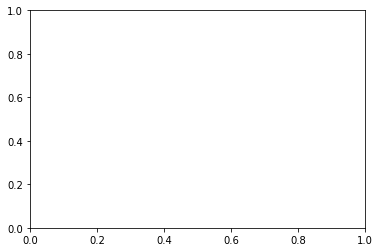

In [253]:
plt.scatter(X_test, y_test,  color='green')
plt.plot(X_test, y_hat_test, color='blue', linewidth=3)

plt.show()

In [258]:
X_test
y_test

5103      692500.0
12331     339900.0
18395     685000.0
4955     1000000.0
11009     315000.0
11743     250000.0
19263     458000.0
711       243000.0
20858     775000.0
4678      690000.0
5944      320000.0
4325      227000.0
18113     765000.0
21194     500000.0
17981    1990000.0
5559      258000.0
756       942500.0
10955     282000.0
3416      375000.0
864       280000.0
2052      297000.0
12371     164000.0
16551     385000.0
8355      782000.0
9275      265000.0
12572     648000.0
6873      327500.0
7855      330000.0
2962      999000.0
6467      503500.0
           ...    
10341     401000.0
20364     500000.0
552       451000.0
6685     2000000.0
8020      480000.0
14979     152500.0
20427     385000.0
6494      755000.0
18812     732000.0
249       481000.0
5033      195000.0
18314    2920000.0
2258      208000.0
7934      450000.0
14022     550000.0
185      1100000.0
3180      440000.0
8504      355000.0
12293     583000.0
6305      367500.0
2883      402000.0
7439      27